In [1]:
import os
import sys

import numpy as np
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.utils as vutils
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

In [11]:
CUDA = True
DATA_PATH = './resize_64'
BATCH_SIZE = 64
IMAGE_CHANNEL = 1
Z_DIM = 100
G_HIDDEN = 64 #64
X_DIM = 64
D_HIDDEN = 64  # 64
EPOCH_NUM = 1250
REAL_LABEL = 1
FAKE_LABEL = 0
lr = 2e-4
seed = 1

in_h = 128
in_w = 128

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input layer
            nn.ConvTranspose2d(Z_DIM, G_HIDDEN * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 8),
            nn.ReLU(True),
            # 1st hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 8, G_HIDDEN * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 4),
            nn.ReLU(True),
            # 2nd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 4, G_HIDDEN * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN * 2),
            nn.ReLU(True),
            # 3rd hidden layer
            nn.ConvTranspose2d(G_HIDDEN * 2, G_HIDDEN, 4, 2, 1, bias=False),
            nn.BatchNorm2d(G_HIDDEN),
            nn.ReLU(True),
            # output layer
            nn.ConvTranspose2d(G_HIDDEN, IMAGE_CHANNEL, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        

    def forward(self, input):
        return self.main(input)
    


torch.Size([64, 1, 64, 64])


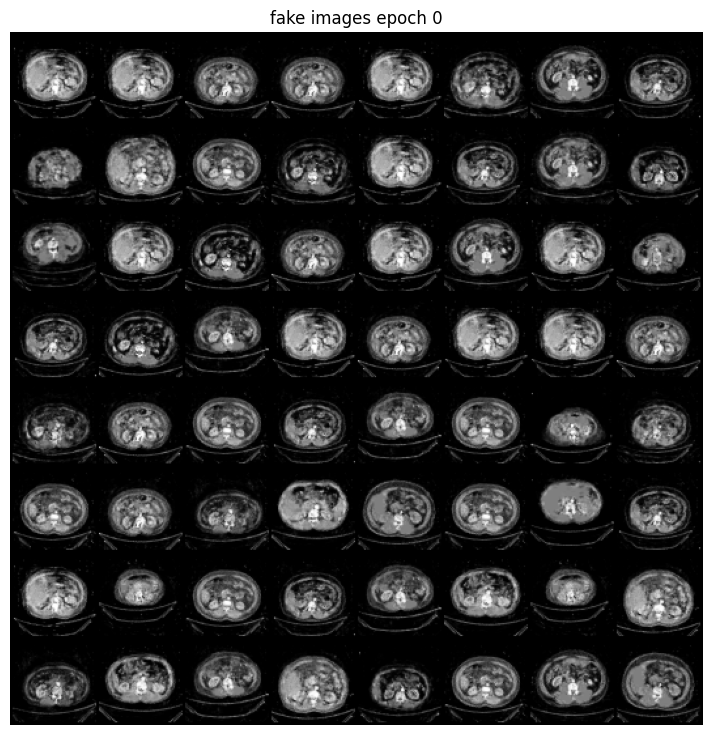

In [25]:
device='cuda'
netG =  torch.load('../dcgan/wgan-dc-1500.pth', map_location=torch.device('cuda'))
# Create batch of latent vectors that I will use to visualize the progression of the generator
viz_noise = torch.randn(BATCH_SIZE, Z_DIM, 1, 1, device='cuda')

fixed_noise = torch.randn(BATCH_SIZE, Z_DIM,1,1,device=device)

with torch.no_grad():
  fake_batch=netG(fixed_noise)
print(fake_batch.shape)
plt.figure(figsize=(9,9))
plt.axis('off')
plt.title('fake images epoch 0')
plt.imshow(np.transpose(vutils.make_grid(fake_batch.to(device).view(BATCH_SIZE,1,64,64)[:64],padding=2, normalize=True).cpu(),(1,2,0)))


In [10]:
from torchvision.models import inception_v3
inception_model = inception_v3(pretrained=False)
inception_model.load_state_dict(torch.load("inception_v3_google-1a9a5a14.pth"))
inception_model.to(device)
inception_model = inception_model.eval() # Evaluation mode

c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [13]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL: inception_model.fc

# You want to replace the final fully-connected (fc) layer 
# with an identity function layer to cut off the classification
# layer and get a feature extractor
#### START CODE HERE ####
inception_model.fc = nn.Identity()
#### END CODE HERE ####
import scipy
# This is the matrix square root function you will be using
def matrix_sqrt(x):
    '''
    Function that takes in a matrix and returns the square root of that matrix.
    For an input matrix A, the output matrix B would be such that B @ B is the matrix A.
    Parameters:
        x: a matrix
    '''
    y = x.cpu().detach().numpy()
    y = scipy.linalg.sqrtm(y)
    return torch.Tensor(y.real, device=x.device)

# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: frechet_distance
def frechet_distance(mu_x, mu_y, sigma_x, sigma_y):
    '''
    Function for returning the Fréchet distance between multivariate Gaussians,
    parameterized by their means and covariance matrices.
    Parameters:
        mu_x: the mean of the first Gaussian, (n_features)
        mu_y: the mean of the second Gaussian, (n_features) 
        sigma_x: the covariance matrix of the first Gaussian, (n_features, n_features)
        sigma_y: the covariance matrix of the second Gaussian, (n_features, n_features)
    '''
    #### START CODE HERE ####
    return torch.norm(mu_x - mu_y, p = 2)**2 + torch.trace(sigma_x + sigma_y - 2*matrix_sqrt(sigma_x@sigma_y))
    #### END CODE HERE ####

import numpy as np
def preprocess(img):
    img = torch.nn.functional.interpolate(img, size=(299, 299), mode='bilinear', align_corners=False)
    return img

def get_covariance(features):
    return torch.Tensor(np.cov(features.detach().numpy(), rowvar=False))

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
from PIL import Image


class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, target_size=(64, 64)):
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        self.image_filenames = [filename for filename in os.listdir(root_dir) if filename.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_filenames[idx])
        image = Image.open(img_name)
        #image = image.resize(self.target_size, Image.LANCZOS)  # Resize image with LANCZOS filter
        if self.transform:
            image = self.transform(image)
        return image


# Define constants
IMAGE_SIZE = (64, 64)
IMAGE_DIR = '../experimental'

print(in_h,in_w)
# Transformation to convert images to PyTorch tensors
transform = transforms.Compose([
    transforms.Resize((in_h,in_w)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Create dataset
dataset = CustomDataset(root_dir=IMAGE_DIR, transform=transform)

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)
# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    return torch.cat([grayscale_images] * 3, dim=1)  #



128 128


In [26]:
from tqdm.auto import tqdm

fake_features_list = []
real_features_list = []

netG.eval()

n_samples = 3274


cur_samples = 0


# Function to resize images to the minimum required size for Inception model
def resize_to_min_size(images, min_size=(299, 299)):
    return F.interpolate(images, size=min_size, mode='bicubic', align_corners=False)

with torch.no_grad(): # You don't need to calculate gradients here, so you do this to save memory
    for real_example in tqdm(dataloader, total=n_samples // BATCH_SIZE): # Go by batch
        real_samples = real_example
        real_samples_rgb = convert_to_rgb(real_samples)
        real_samples_resized = resize_to_min_size(real_samples_rgb)  # Resize to minimum required size
        real_features = inception_model(real_samples_resized.to(device)).detach().to('cpu') # Move features to CPU
        real_features_list.append(real_features)
        ## 
        fixed_noise = torch.randn(BATCH_SIZE, Z_DIM,1,1,device=device)
        #fake_samples = get_noise(len(real_example), Z_DIM).to(device)
        print(fixed_noise.shape)
        disc = netG(fixed_noise)
        fake_samples = preprocess(disc)
        
        fake_samples_rgb = convert_to_rgb(fake_samples)  # Convert fake samples to RGB
        fake_samples_resized = resize_to_min_size(fake_samples_rgb)  # Resize to minimum required size
        fake_features = inception_model(fake_samples_resized.to(device)).detach().to('cpu')
        fake_features_list.append(fake_features)
        cur_samples += len(real_samples)
        if cur_samples > n_samples:
            break   

# Function to convert grayscale images to RGB
def convert_to_rgb(grayscale_images):
    # Replicate single channel to create three channels
    return grayscale_images.repeat(1, 3, 1, 1)



  0%|          | 0/51 [00:00<?, ?it/s]

torch.Size([64, 100, 1, 1])


  2%|▏         | 1/51 [00:01<01:37,  1.95s/it]

torch.Size([64, 100, 1, 1])


  4%|▍         | 2/51 [00:03<01:11,  1.47s/it]

torch.Size([64, 100, 1, 1])


  6%|▌         | 3/51 [00:04<01:02,  1.30s/it]

torch.Size([64, 100, 1, 1])


  8%|▊         | 4/51 [00:05<00:57,  1.22s/it]

torch.Size([64, 100, 1, 1])


 10%|▉         | 5/51 [00:06<00:54,  1.19s/it]

torch.Size([64, 100, 1, 1])


 12%|█▏        | 6/51 [00:07<00:52,  1.17s/it]

torch.Size([64, 100, 1, 1])


 14%|█▎        | 7/51 [00:08<00:51,  1.17s/it]

torch.Size([64, 100, 1, 1])


 16%|█▌        | 8/51 [00:09<00:50,  1.17s/it]

torch.Size([64, 100, 1, 1])


 18%|█▊        | 9/51 [00:11<00:49,  1.17s/it]

torch.Size([64, 100, 1, 1])


 20%|█▉        | 10/51 [00:12<00:48,  1.18s/it]

torch.Size([64, 100, 1, 1])


 22%|██▏       | 11/51 [00:13<00:47,  1.18s/it]

torch.Size([64, 100, 1, 1])


 24%|██▎       | 12/51 [00:14<00:45,  1.17s/it]

torch.Size([64, 100, 1, 1])


 25%|██▌       | 13/51 [00:15<00:44,  1.16s/it]

torch.Size([64, 100, 1, 1])


 27%|██▋       | 14/51 [00:16<00:42,  1.16s/it]

torch.Size([64, 100, 1, 1])


 29%|██▉       | 15/51 [00:18<00:41,  1.16s/it]

torch.Size([64, 100, 1, 1])


 31%|███▏      | 16/51 [00:19<00:40,  1.15s/it]

torch.Size([64, 100, 1, 1])


 33%|███▎      | 17/51 [00:20<00:39,  1.16s/it]

torch.Size([64, 100, 1, 1])


 35%|███▌      | 18/51 [00:21<00:40,  1.23s/it]

torch.Size([64, 100, 1, 1])


 37%|███▋      | 19/51 [00:22<00:38,  1.21s/it]

torch.Size([64, 100, 1, 1])


 39%|███▉      | 20/51 [00:24<00:37,  1.20s/it]

torch.Size([64, 100, 1, 1])


 41%|████      | 21/51 [00:25<00:35,  1.19s/it]

torch.Size([64, 100, 1, 1])


 43%|████▎     | 22/51 [00:26<00:33,  1.17s/it]

torch.Size([64, 100, 1, 1])


 45%|████▌     | 23/51 [00:27<00:32,  1.15s/it]

torch.Size([64, 100, 1, 1])


 47%|████▋     | 24/51 [00:28<00:31,  1.16s/it]

torch.Size([64, 100, 1, 1])


 49%|████▉     | 25/51 [00:29<00:29,  1.15s/it]

torch.Size([64, 100, 1, 1])


 51%|█████     | 26/51 [00:30<00:29,  1.16s/it]

torch.Size([64, 100, 1, 1])


 53%|█████▎    | 27/51 [00:32<00:28,  1.17s/it]

torch.Size([64, 100, 1, 1])


 55%|█████▍    | 28/51 [00:33<00:26,  1.17s/it]

torch.Size([64, 100, 1, 1])


 57%|█████▋    | 29/51 [00:34<00:25,  1.16s/it]

torch.Size([64, 100, 1, 1])


 59%|█████▉    | 30/51 [00:35<00:24,  1.16s/it]

torch.Size([64, 100, 1, 1])


 61%|██████    | 31/51 [00:36<00:23,  1.16s/it]

torch.Size([64, 100, 1, 1])


 63%|██████▎   | 32/51 [00:37<00:22,  1.16s/it]

torch.Size([64, 100, 1, 1])


 65%|██████▍   | 33/51 [00:39<00:21,  1.17s/it]

torch.Size([64, 100, 1, 1])


 67%|██████▋   | 34/51 [00:40<00:19,  1.15s/it]

torch.Size([64, 100, 1, 1])


 69%|██████▊   | 35/51 [00:41<00:18,  1.15s/it]

torch.Size([64, 100, 1, 1])


 71%|███████   | 36/51 [00:42<00:17,  1.15s/it]

torch.Size([64, 100, 1, 1])


 73%|███████▎  | 37/51 [00:43<00:16,  1.15s/it]

torch.Size([64, 100, 1, 1])


 75%|███████▍  | 38/51 [00:44<00:15,  1.16s/it]

torch.Size([64, 100, 1, 1])


 76%|███████▋  | 39/51 [00:46<00:13,  1.16s/it]

torch.Size([64, 100, 1, 1])


 78%|███████▊  | 40/51 [00:47<00:12,  1.17s/it]

torch.Size([64, 100, 1, 1])


 80%|████████  | 41/51 [00:48<00:11,  1.16s/it]

torch.Size([64, 100, 1, 1])


 82%|████████▏ | 42/51 [00:49<00:10,  1.21s/it]

torch.Size([64, 100, 1, 1])


 84%|████████▍ | 43/51 [00:50<00:09,  1.20s/it]

torch.Size([64, 100, 1, 1])


 86%|████████▋ | 44/51 [00:52<00:08,  1.19s/it]

torch.Size([64, 100, 1, 1])


 88%|████████▊ | 45/51 [00:53<00:07,  1.19s/it]

torch.Size([64, 100, 1, 1])


 90%|█████████ | 46/51 [00:54<00:05,  1.18s/it]

torch.Size([64, 100, 1, 1])


 92%|█████████▏| 47/51 [00:55<00:04,  1.18s/it]

torch.Size([64, 100, 1, 1])


 94%|█████████▍| 48/51 [00:56<00:03,  1.18s/it]

torch.Size([64, 100, 1, 1])


 96%|█████████▌| 49/51 [00:57<00:02,  1.17s/it]

torch.Size([64, 100, 1, 1])


 98%|█████████▊| 50/51 [00:59<00:01,  1.15s/it]

torch.Size([64, 100, 1, 1])


100%|██████████| 51/51 [01:00<00:00,  1.16s/it]

torch.Size([64, 100, 1, 1])


52it [01:00,  1.17s/it]                        


In [27]:
from torch.distributions import MultivariateNormal
import seaborn as sns # This is for visualization
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# UNIT TEST COMMENT: Needed as is for autograding
fake_features_all = torch.cat(fake_features_list)
real_features_all = torch.cat(real_features_list)

# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL

# Calculate the covariance matrix for the fake and real features
# and also calculate the means of the feature over the batch (for each feature dimension mean)
#### START CODE HERE ####
mu_fake = torch.mean(fake_features_all, dim=0)
mu_real = torch.mean(real_features_all, dim=0)
sigma_fake = get_covariance(fake_features_all)
sigma_real = get_covariance(real_features_all)
#### END CODE HERE ####

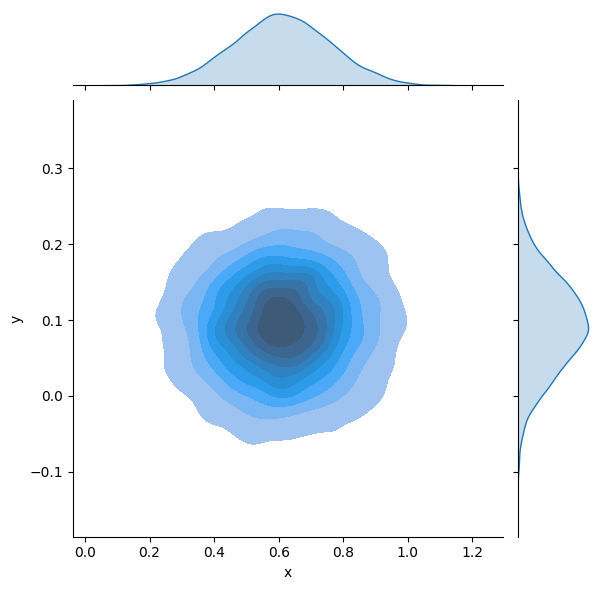

In [28]:
## LEVEL CURVES FOR FAKE VARIANCE
fake_dist = MultivariateNormal(mu_fake, sigma_fake)
fake_samples = fake_dist.sample((10000,))
fakeplot = sns.jointplot(x=fake_samples[:, 0], y=fake_samples[:, 1], kind="kde", fill=True)
fakeplot.set_axis_labels("feature 1", "feature 2") 
plt.show()

c:\Users\Artur\anaconda3\envs\lighthouse\lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


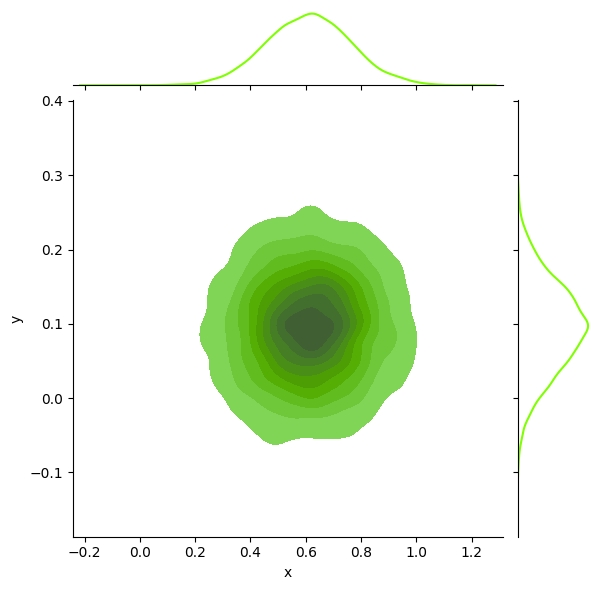

In [29]:
real_dist = MultivariateNormal(mu_fake, sigma_fake)
real_samples = real_dist.sample((10000,))
realplot = sns.jointplot(x=real_samples[:, 0], y=real_samples[:, 1], kind="kde",color='chartreuse', shade=True)
realplot.set_axis_labels("feature 1", "feature 2") 
plt.show()

In [ ]:
# Create joint plots with shaded level curves and labeled axes
#fakeplot = sns.jointplot(x=fake_samples[:, 0], y=fake_samples[:, 1], kind="kde", shade=True, color="b", alpha=0.5)
#realplot = sns.jointplot(x=real_samples[:, 0], y=real_samples[:, 1], kind="kde", shade=True, color="orange", alpha=0.5)

# Overlay the plots
plt.figure(figsize=(10, 5))
plt.subplot(121)  # Fake distribution
sns.kdeplot(x=fake_samples[:, 0], y=fake_samples[:, 1], cmap="Purples_r", fill=True, alpha=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Fake Distribution")
plt.subplot(122)  # Real distribution
sns.kdeplot(x=real_samples[:, 0], y=real_samples[:, 1], cmap="YlGn_r", fill=True, alpha=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Real Distribution")
plt.tight_layout()
plt.show()

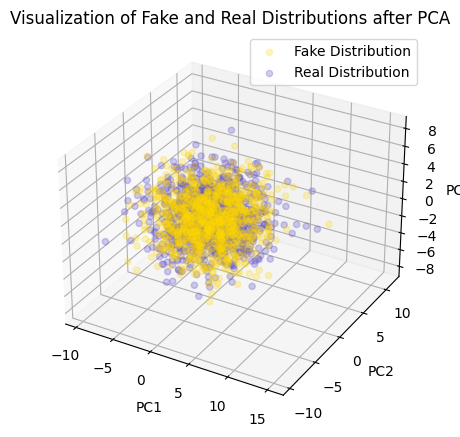

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Sample from the distributions
samples_fake = fake_dist.sample((1000,)).numpy()
samples_real = real_dist.sample((1000,)).numpy()

# Apply PCA to reduce dimensionality to 3 for both fake and real samples
pca = PCA(n_components=3)
samples_fake_pca = pca.fit_transform(samples_fake)
samples_real_pca = pca.transform(samples_real)

# Plot 3D scatter plot
fig = plt.figure(figsize=(5, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot the samples after PCA for fake distribution
ax.scatter(samples_fake_pca[:, 0], samples_fake_pca[:, 1], samples_fake_pca[:, 2],color='gold', alpha=0.24, label='Fake Distribution')

# Plot the samples after PCA for real distribution
ax.scatter(samples_real_pca[:, 0], samples_real_pca[:, 1], samples_real_pca[:, 2],color='slateblue', alpha=0.3, label='Real Distribution')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Visualization of Fake and Real Distributions after PCA')
ax.legend()

plt.show()


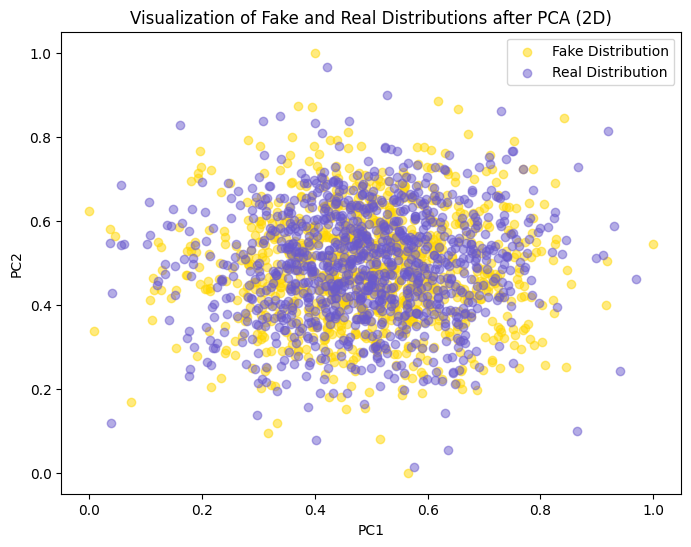

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Sample from the distributions
samples_fake = fake_dist.sample((1000,)).numpy()
samples_real = real_dist.sample((1000,)).numpy()

# Apply PCA to reduce dimensionality to 2 for both fake and real samples
pca = PCA(n_components=2)
samples_fake_pca = pca.fit_transform(samples_fake)
samples_real_pca = pca.transform(samples_real)

# Normalize the principal components to have similar scales
scaler = MinMaxScaler()
samples_fake_pca_scaled = scaler.fit_transform(samples_fake_pca)
samples_real_pca_scaled = scaler.transform(samples_real_pca)

# Plot 2D scatter plot
plt.figure(figsize=(8, 6))

# Plot the samples after PCA for fake distribution
plt.scatter(samples_fake_pca_scaled[:, 0], samples_fake_pca_scaled[:, 1], color='gold', alpha=0.5, label='Fake Distribution')

# Plot the samples after PCA for real distribution
plt.scatter(samples_real_pca_scaled[:, 0], samples_real_pca_scaled[:, 1], color='slateblue', alpha=0.5, label='Real Distribution')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualization of Fake and Real Distributions after PCA (2D)')
plt.legend()

plt.show()


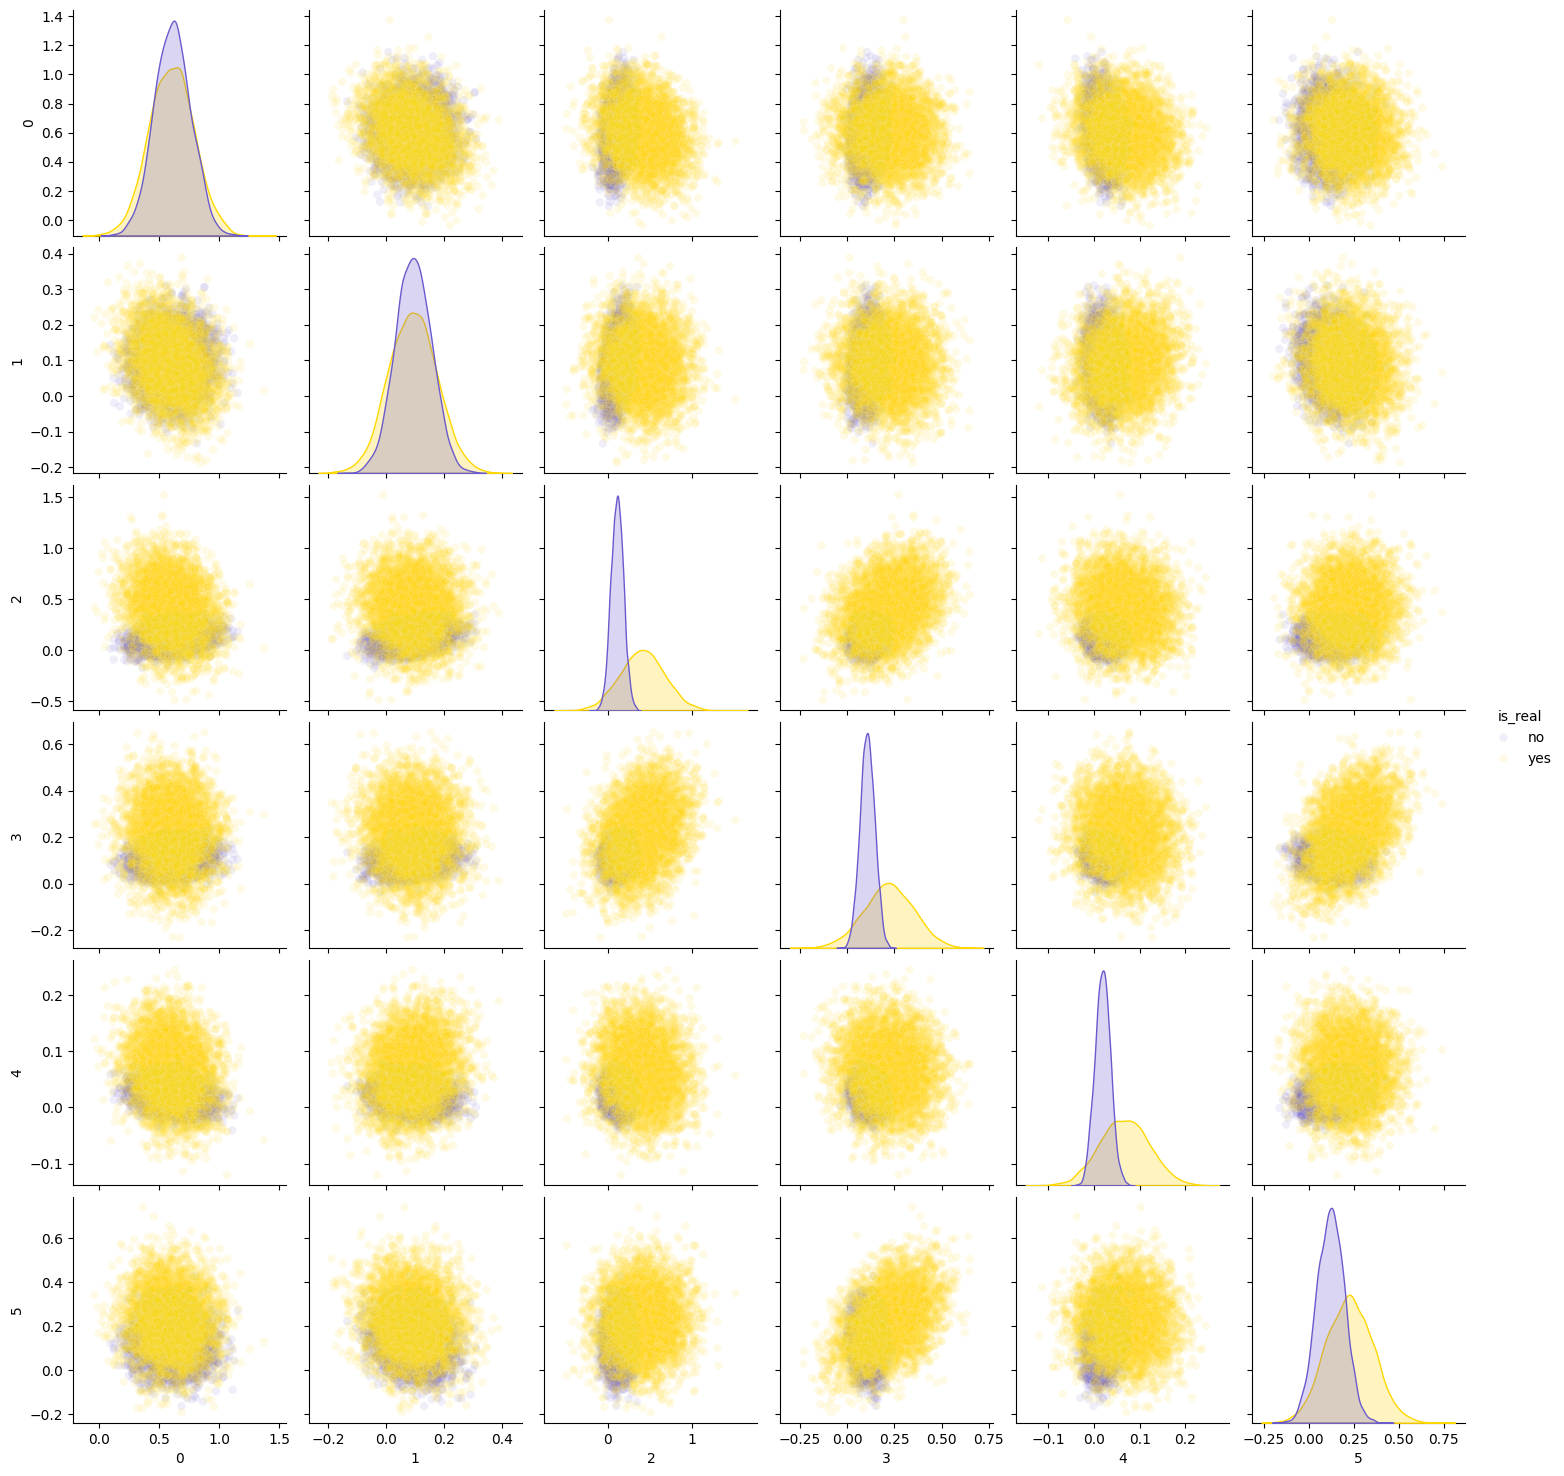

In [35]:
indices = [0,1,2,3,4,5]
fake_dist = MultivariateNormal(mu_fake[indices], sigma_fake[indices][:, indices])
fake_samples = fake_dist.sample((5000,))
real_dist = MultivariateNormal(mu_real[indices], sigma_real[indices][:, indices])
real_samples = real_dist.sample((5000,))

import pandas as pd
df_fake = pd.DataFrame(fake_samples.numpy(), columns=indices)
df_real = pd.DataFrame(real_samples.numpy(), columns=indices)
df_fake["is_real"] = "no"
df_real["is_real"] = "yes"
df = pd.concat([df_fake, df_real])
sns.pairplot(data = df, plot_kws={'alpha': 0.1}, hue='is_real', palette={"no":"slateblue","yes":"gold"})
plt.show()


In [36]:
with torch.no_grad():
    print(frechet_distance(mu_real, mu_fake, sigma_real, sigma_fake).item())

149.76527404785156
